In [1]:
import numpy as np
import scipy as sp 
from methods import *
import matplotlib.pyplot as plt
from magnus_methods import *

#### a)

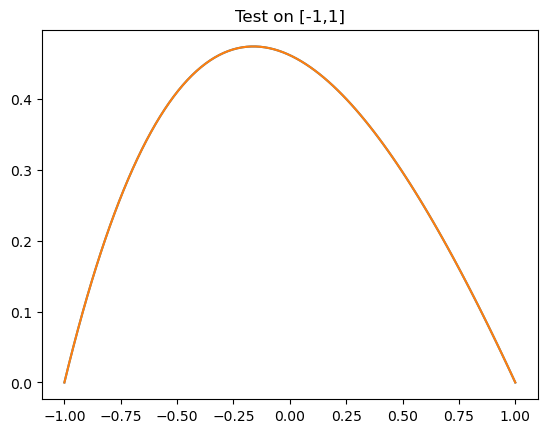

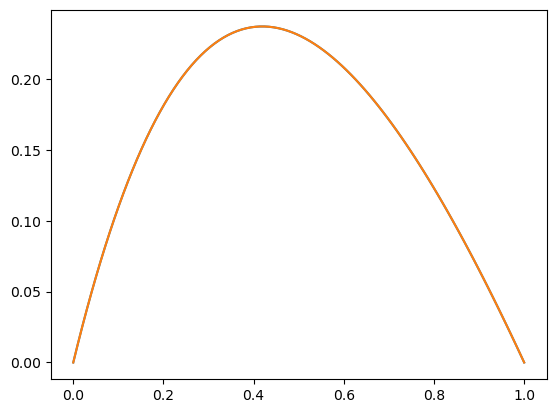

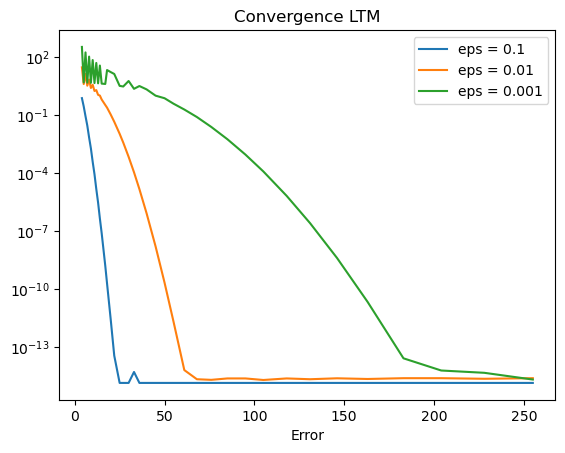

In [2]:
def ffun(x):
    return 1
ffun = np.vectorize(ffun)

def utrue(x,eps):
    return ( np.exp(-x/eps) + x - 1 - np.exp(-1/eps)*x )/( np.exp(-1/eps) - 1 )
utrue = np.vectorize(utrue)

def testtrue(x):
    return ( np.exp(2) + 1 - 2*np.exp(1-x) )/(np.exp(2) - 1) - x
testtrue = np.vectorize(testtrue)

m = 100
#X = np.arange(m)/m*2 - 1
X = np.linspace(-1,1,m)

testsol = LTM_2ord(X, 8, -1, -1,1)

plt.figure
plt.plot(X,testtrue(X))
plt.plot(X,testsol)
plt.title("Test on [-1,1]")
plt.show()


XX = np.linspace(0,1,m)
eps = 0.5
usol = LTM_2ord(XX*2-1,16,-4*eps,-2,1)
plt.figure()
plt.plot(XX,utrue(XX,eps))
plt.plot(XX,usol)
plt.show()


# convergence
EPS = [0.1,0.01,0.001]
Ns = np.ceil(np.logspace(0,2.4,50))+3
err = np.empty_like(Ns)
plt.figure()
for e in EPS:
    for i in range(len(Ns)):
        urec = LTM_2ord(XX*2-1,int(Ns[i]),-4*e,-2,1)
        err[i] = np.linalg.norm(utrue(XX,e) - urec)
    plt.semilogy(Ns,err,label=f"eps = {e}")
plt.title("Convergence LTM")
plt.xlabel("Number of basis polynomials")
plt.xlabel("Error")
plt.legend()
plt.show()


### Part 3
#### 4)

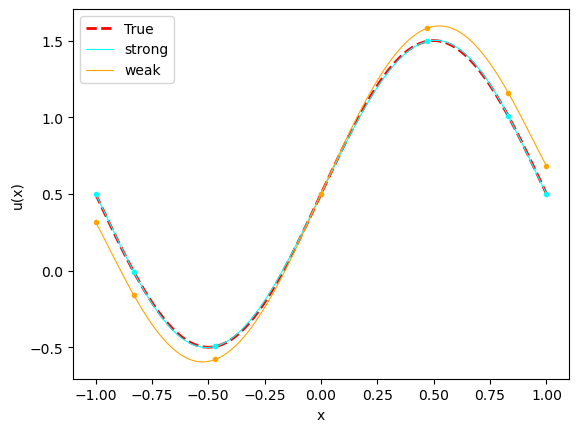

In [3]:
P = 6
def ffun(t):
    return np.pi**2*np.sin(np.pi*t)
ffun = np.vectorize(ffun)
def utrue(t):
    return np.sin(np.pi*t)+0.5
utrue = np.vectorize(utrue)
XX = np.arange(101)/100*2-1



us,r,_ = SBM(P, utrue(-1),utrue(1),ffun=ffun,method='strong_CBM')
uw,r,_ = SBM(P, utrue(-1),utrue(1),ffun=ffun,method='weak_CBM',tau=1)

V = JacobiP(r,0,0,P,True).T
Vi = np.linalg.inv(V)
Phi = JacobiP(XX,0,0,P,matrix=True).T
H = Phi@Vi

plt.figure
plt.plot(XX,utrue(XX),'--',label='True',color='r',linewidth=2)
plt.plot(XX,H@us,label='strong',linewidth=0.8,color='cyan')
plt.plot(r,us,'.',color='cyan')
plt.plot(XX,H@uw,label='weak',linewidth=0.8,color='orange')
plt.plot(r,uw,'.',color='orange')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()





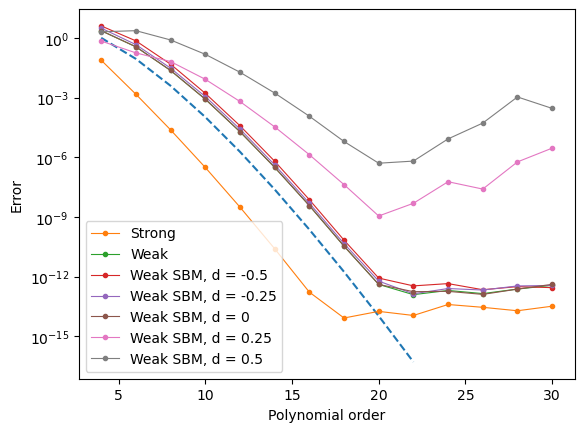

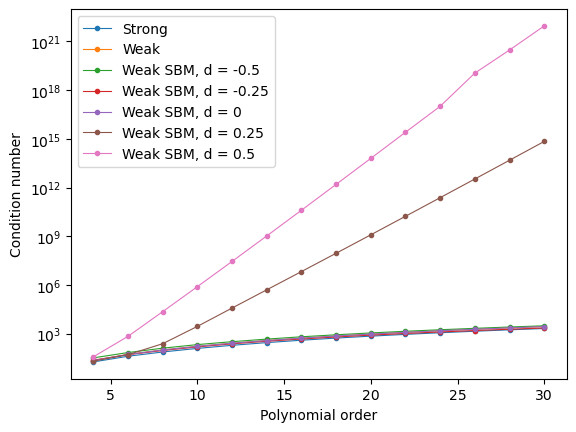

In [4]:
Ns = np.arange(2,16)*2
Ds = [-0.5,-0.25,0,0.25,0.5]
err = np.empty((2+len(Ds),len(Ns)))
CA = np.empty(err.shape)

for i in range(len(Ns)):
    M = massGL(int(Ns[i]))
    us,r,ca = SBM(int(Ns[i]), utrue(-1),utrue(1),ffun=ffun,method='strong_CBM')
    err[0,i] = np.linalg.norm(us-utrue(r))
    CA[0,i] = ca
    uw,r,ca = SBM(int(Ns[i]), utrue(-1),utrue(1),ffun=ffun,method='weak_CBM')
    err[1,i] = np.linalg.norm(uw-utrue(r))
    CA[1,i] = ca
    for j in range(len(Ds)):
        usbm,r, ca = SBM(int(Ns[i]), utrue(-1-Ds[j]),utrue(1+Ds[j]),ffun=ffun,method='weak_SBM',d=Ds[j])
        err[2+j,i] = np.linalg.norm(usbm-utrue(r))
        CA[2+j,i] = ca

plt.figure
lw = 0.8
ms = 3
plt.semilogy(Ns[:10],[(n/4)**(-float(n)) for n in Ns[:10]],'--')
plt.semilogy(Ns,err[0],'o-',label='Strong',linewidth=lw,markersize=ms)
plt.semilogy(Ns,err[1],'o-',label='Weak',linewidth=lw,markersize=ms)
for i in range(len(Ds)):
    plt.semilogy(Ns,err[2+i],'o-',label='Weak SBM, d = {}'.format(Ds[i]),linewidth=lw,markersize=ms)
plt.legend()
plt.xlabel('Polynomial order')
plt.ylabel('Error')
plt.show()

plt.figure
lw = 0.8
ms = 3
plt.semilogy(Ns,CA[0],'o-',label='Strong',linewidth=lw,markersize=ms)
plt.semilogy(Ns,CA[1],'o-',label='Weak',linewidth=lw,markersize=ms)
for i in range(len(Ds)):
    plt.semilogy(Ns,CA[2+i],'o-',label='Weak SBM, d = {}'.format(Ds[i]),linewidth=lw,markersize=ms)
plt.legend()
plt.xlabel('Polynomial order')
plt.ylabel('Condition number')
plt.show()

In [31]:
np.arange(-5,5,1)

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

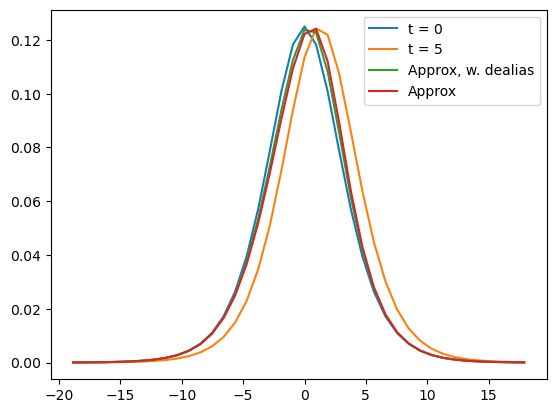

In [12]:

from methods import *
from scipy.integrate import RK23, RK45, solve_ivp

def sech(x):
    return 2*np.exp(x)/(np.exp(2*x)+1)

def true_u(x,t,c,x0):
    return 1/2*c*sech(1/2*np.sqrt(c)*(x-c*t-x0))**2
true_u = np.vectorize(true_u)

def Dealias_orzag(u, v):
    uhat = np.fft.fft(u)
    vhat = np.fft.fft(v)
    N = len(uhat)
    M = int(np.ceil(3/2*N))
    uhatpad = np.concatenate((uhat[:N//2], np.zeros(M - N), uhat[N//2:]))
    vhatpad = np.concatenate((vhat[:N//2], np.zeros(M - N), vhat[N//2:]))
    upad = np.fft.ifft(uhatpad)
    vpad = np.fft.ifft(vhatpad)
    wpad = upad * vpad
    wpad_hat = np.fft.fft(wpad)
    what = np.concatenate((wpad_hat[:N//2], wpad_hat[M - N//2:M]))
    return np.fft.ifft(what).real

def fourier_diff(f,scale):
    N = len(f)
    dx = 2*np.pi*scale/N
    kk = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    return np.fft.ifft( 1j * kk * np.fft.fft(f) ).real/scale

N = 40
#xx = [j*np.pi*4/N-2*np.pi for j in range (N)]
xx = np.arange(N)/N*2*np.pi
Dx = Dmatrix_Fourier(N,xx)
scale = 6
trans = -scale*np.pi
xx = scale*xx + trans 
Dx = Dx/scale

dealias = True

def RHS(t,u):
    if dealias:
        w = Dealias_orzag(u,fourier_diff(u,scale))
    else:
        w = u*fourier_diff(u,scale)
    return -(6*w+fourier_diff(fourier_diff(fourier_diff(u,scale),scale),scale))
#RHS = np.vectorize(RHS)

c = 0.25
x0 = np.zeros(N)
t0 = 0
tf = 5

y0 = true_u(xx,t=t0,c=c,x0=x0)
hmm = 6*y0*fourier_diff(y0,scale)+fourier_diff(fourier_diff(fourier_diff(y0,scale),scale),scale)
test = RHS(t0,y0)

def max_step(alpha,N,c):
    return alpha*1.73/(N**3/8-3*N*0.5*c)
alpha = 0.9


#time_solver = RK23(RHS,t0=0,y0=y0,t_bound=0.1,vectorized=True)
sol = solve_ivp(RHS,t_span=[t0,tf],y0=y0,method='RK23',max_step=max_step(alpha,N,c))
times = sol.t
uhat = sol.y

plt.figure()
plt.plot(xx,true_u(xx,t=0,c=c,x0=np.zeros(N)),label=f"t = {t0}")
plt.plot(xx,true_u(xx,t=tf,c=c,x0=np.zeros(N)),label=f"t = {tf}")
plt.plot(xx,uhat[:,-1],label="Approx, w. dealias")
dealias = False
sol = solve_ivp(RHS,t_span=[t0,tf],y0=y0,method='RK23')
times = sol.t
uhat = sol.y
plt.plot(xx,uhat[:,-1],label="Approx")
plt.legend()

christians stuff

Max time step used in RK3: 0.0021557632398753893
Max time step used in RK3: 0.0021761006289308174
Max time step used in RK3: 0.002217948717948718


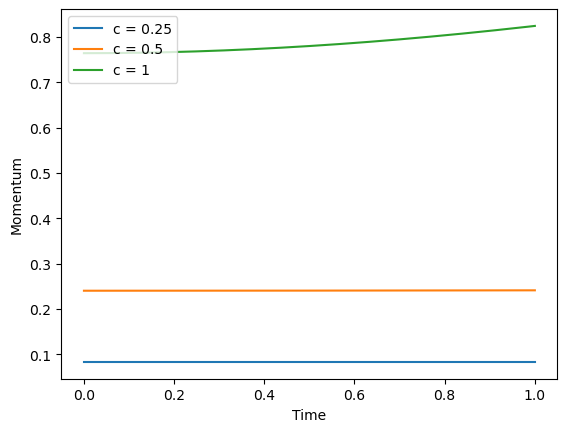

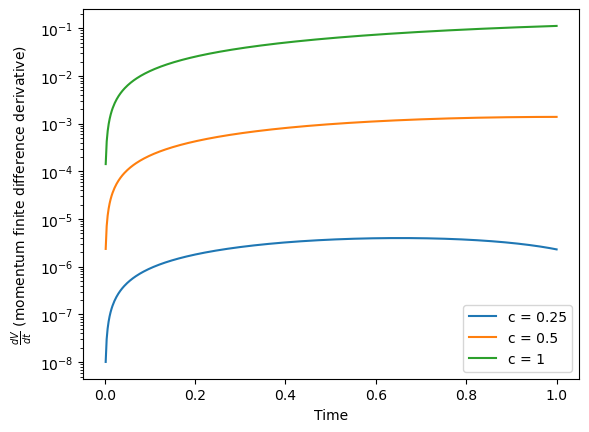

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from methods import *
from scipy.integrate import RK23, RK45, solve_ivp

import warnings
warnings.filterwarnings('ignore')

def tran(x): # transform coordinates
    return None

def sech_squared(x):
    return (2*np.exp(x)/(np.exp(2*x)+1))**2

def true_u(x,t,c,x0):
    return 1/2*c*sech_squared(1/2*np.sqrt(c)*(x-c*t-x0))
true_u = np.vectorize(true_u)

def Dealias_orzag(u, v):
    uhat = np.fft.fft(u)
    vhat = np.fft.fft(v)
    N = len(uhat)
    M = int(np.ceil(3/2*N))
    uhatpad = np.concatenate((uhat[:N//2], np.zeros(M - N), uhat[(N//2):]))
    vhatpad = np.concatenate((vhat[:N//2], np.zeros(M - N), vhat[(N//2):]))
    upad = np.fft.ifft(uhatpad)
    vpad = np.fft.ifft(vhatpad)
    wpad = upad * vpad
    wpad_hat = np.fft.fft(wpad)
    what = 3/2*np.concatenate((wpad_hat[:N//2], wpad_hat[M - N//2:M]))
    return np.fft.ifft(what).real

def Dealias_IC(IC,N):
    MM = len(IC)
    uuhat0 = np.fft.fft(IC) / MM  # normalization
    uuhat0 = np.fft.fftshift(uuhat0)  # reorder
    idx = np.round((MM - 1) / 2 + np.arange(-(N - 1) / 2, (N - 1) / 2 + 1)).astype(int) + np.mod(MM, 2)
    uu1 = np.fft.ifft(np.fft.ifftshift(uuhat0[idx]) * N)
    return uu1

# def Dealias_IC(IC):
#     N = len(IC)
#     thres = N//2
#     IChat = np.fft.fft(IC)
#     # plt.figure
#     # plt.semilogy(abs(IChat))
#     # truncation
#     IChat[thres:-thres] = 0
#     # plt.semilogy(abs(IChat),label='trunc')
#     # plt.legend()
#     # plt.title('IC in modal space')
#     # plt.show()
#     return np.fft.ifft(IChat).real

def fft_diff(f, N, L):
    
    fhat = sp.fft.fft(f)
    k = (2*np.pi/L)*np.arange(-N/2,N/2)
    k = sp.fft.fftshift(k)
    dfhat = k*fhat*(1j)
    return np.real(sp.fft.ifft(dfhat))

# Choose de-aliasing or not
dealias_orzag = False
dealias_IC = False

# Choose to use fft in diff. operations
use_fft = True

# Choose what to plot
plot_options = ["plot_norm_error","plot_max_error","plot_M","plot_V","plot_E","plot_coeff",
                "plot_N_convergence","plot_two_soltions","plot_approximation","plot_convergence"]
plot_opt = "plot_V"

# Choose domain size
x1 = -8*np.pi
x2 = 8*np.pi

# Choose alpha for time step heurestic
alpha = 0.9

####################################
if plot_opt == "plot_N_convergence":
    Ns = [10,20,30,40,50]
    cs = [0.25,0.5,1]
    tf = 1
    plt.figure()
elif plot_opt == "plot_coeff":
    Ns = [40]
    cs = [0.5]
    tf = 12
    plt.figure()
elif plot_opt == "plot_convergence":
    Ns = np.arange(1,11)*6
    cs = [0.25]
    tf = 1
else:
    Ns = [18]
    cs = [0.25,0.5,1]
    tf = 1

for c in cs:
    N_errors = []
    for N in Ns:
        x0 = np.zeros(N)
        t0 = 0
        if use_fft:
            L = x2-x1
            h = L/N
            xx = np.arange(-L/2,L/2,h)
        else:
            xx = [j*x2*2/(N)+x1 for j in range (N)]
            xx_2pi = [j*np.pi*2/(N) for j in range (N)]
            Dx = Dmatrix_Fourier(N,xx_2pi)*(2*np.pi)/(x2-x1)
        
        def RHS(t,u):
            if dealias_orzag:
                if use_fft:
                    w = Dealias_orzag(u,fft_diff(u,N,x2-x1))
                    return -(6*w+fft_diff(fft_diff(fft_diff(u,N,x2-x1),N,x2-x1),N,x2-x1))
                else:
                    w = Dealias_orzag(u,Dx@u)
                    return -(6*w+Dx@Dx@Dx@u)
            else:
                if use_fft:
                    return -(6*u*fft_diff(u,N,x2-x1)+fft_diff(fft_diff(fft_diff(u,N,x2-x1),N,x2-x1),N,x2-x1))
                else:
                    return -(6*u*Dx@u+Dx@Dx@Dx@u)

        if dealias_IC:
            N_fine = 500
            xx_fine = [j*x2*2/N_fine+x1 for j in range (N_fine)]
            y0 = Dealias_IC(true_u(xx_fine,t=t0,c=c,x0=np.zeros(N_fine)),N)
            #y0 = Dealias_IC(true_u(xx,t=t0,c=c,x0=x0))
        else:
            y0 = true_u(xx,t=t0,c=c,x0=x0)

        def max_step(alpha,N,c):
            return alpha*1.73/((N**3/8)-3*N*0.5*c)
        
        MAX_step = max_step(alpha=alpha,N=N,c=c)
        print(f"Max time step used in RK3: {MAX_step}")
        sol = solve_ivp(RHS,t_span=[t0,tf],y0=y0,method="RK23",max_step=MAX_step)
        times = sol.t
        uhat = sol.y

        if plot_opt == "plot_max_error":
            max_errors = []
            for i in range(len(times)):
                true = true_u(xx,t=times[i],c=c,x0=x0)
                max_errors.append(np.max(true-uhat[:,i]))
            plt.semilogy(times,max_errors,label=f"max error with c = {c}")
            plt.xlabel("Time")
            plt.ylabel(r'$\|\mathcal{I}_N u - u \|_{\infty}$')
            plt.legend()

        if plot_opt == "plot_norm_error":
            norm_errors = []
            for i in range(len(times)):
                true = true_u(xx,t=times[i],c=c,x0=x0)
                norm_errors.append(np.linalg.norm(true-uhat[:,i]))
            plt.semilogy(times,norm_errors,label=f"2-norm error with c = {c}")
            plt.xlabel("Time")
            plt.ylabel(r'$\|\mathcal{I}_N u - u \|_2$')
            plt.legend()
        
        if plot_opt == "plot_M":
            Ms = []
            for i in range(len(times)):
                Ms.append(h*np.sum(uhat[:,i]))
            plt.figure(1)
            plt.plot(times,Ms,label=f"c = {c}")
            plt.ylabel("Mass")
            plt.xlabel("Time")
            plt.legend(loc=2)

            plt.figure(2)
            plt.plot(times[1:],(np.diff(Ms)/np.diff(times)),label=f'c = {c}')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel(r'$\frac{dM}{dt}$ (mass finite difference derivative)')


        if plot_opt == "plot_V":
            Vs = []
            for i in range(len(times)):
                Vs.append(np.linalg.norm( np.sqrt(h)*(uhat[:,i]) )**2)
            plt.figure(1)
            plt.plot(times,Vs,label=f"c = {c}")
            plt.ylabel("Momentum")
            plt.xlabel("Time")
            plt.legend(loc=2)

            plt.figure(2)
            plt.semilogy(times[1:],(np.diff(Vs)/np.diff(times)),label=f'c = {c}')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel(r'$\frac{dV}{dt}$ (momentum finite difference derivative)')

        if plot_opt == "plot_E":
            Es = []
            if use_fft:
                for i in range(len(times)):
                    Es.append(h*np.sum(1/2*fft_diff(uhat[:,i],N,L)**2+uhat[:,i]**3))
            else:
                for i in range(len(times)):
                    Es.append(h*np.sum(1/2*(Dx@uhat[:,i])**2+uhat[:,i]**3))
            plt.figure(1)
            plt.semilogy(times,Es,label=f"c = {c}")
            plt.ylabel("Energy")
            plt.xlabel("Time")
            plt.legend(loc=2)

            plt.figure(2)
            plt.plot(times[1:],(np.diff(Es)/np.diff(times)),label=f'c = {c}')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel(r'$\frac{dE}{dt}$ (energy finite difference derivative)')
        
        if plot_opt == "plot_coeff":
            coeff_high = []
            coeff_med = []
            coeff_low = []
            coeff_lower = []
            for i in range(len(times)):
                fourier = abs(np.fft.fft(uhat[:,i]))
                coeff_lower.append(fourier[10])
                coeff_low.append(fourier[12])
                coeff_med.append(fourier[14])
                coeff_high.append(fourier[16])

            plt.semilogy(times,coeff_lower,label=r'$\tilde{c}_{10}$')
            plt.semilogy(times,coeff_low,label=r'$\tilde{c}_{12}$')
            plt.semilogy(times,coeff_med,label=r'$\tilde{c}_{14}$')
            plt.semilogy(times,coeff_high,label=r'$\tilde{c}_{16}$')
            
            plt.ylabel(r'$|c_{n}|$')
            plt.xlabel("Time")
            plt.legend(loc=4)

        if plot_opt == "plot_N_convergence":
            true = true_u(xx,t=tf,c=c,x0=x0)
            N_errors.append(np.max((uhat[:,-1]-true)))
        
        if plot_opt == "plot_convergence":
            true = true_u(xx,t=tf,c=c,x0=x0)
            N_errors.append(np.sqrt(h)*np.linalg.norm((uhat[:,-1]-true)))

    if plot_opt == "plot_N_convergence":
        plt.semilogy(Ns,N_errors,label=f"c={c}")
        plt.xlabel("N")
        plt.ylabel(r'$\|\mathcal{I}_N u - u \|_{\infty}$')
    
    if plot_opt == "plot_convergence":
        plt.semilogy(Ns,N_errors,'.--',label=f"c={c}"+f', t={tf}')
        plt.xlabel("N")
        plt.ylabel(r'$\|\mathcal{I}_N u - u \|_{2}$')

if (plot_opt == "plot_N_convergence") or (plot_opt == "plot_convergence"):
    plt.legend()

if plot_opt == "plot_approximation":
    N_fine = N*10
    xx_fine = [j*x2*2/N_fine+x1 for j in range (N_fine)]
    true_final = true_u(xx_fine,t=tf,c=c,x0=np.zeros(N_fine))
    uhat_final = uhat[:,-1]
    plt.figure()
    plt.plot(xx_fine,true_final,label=f"True solution at t = {tf}")
    plt.plot(xx,uhat_final,'o',label=f"Approximation at t = {tf}")
    print(f"2-norm error at time {tf}: {np.linalg.norm(true_u(xx,t=tf,c=c,x0=x0)-uhat[:,-1])}")
    plt.ylabel("u(x,t)")
    plt.xlabel("x")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(xx,(uhat_final-true_u(xx,t=tf,c=c,x0=np.zeros(len(xx)))))
    plt.show()

    plt.figure()
    plt.plot(np.fft.fft(uhat_final))
    plt.show()
